<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
    <tr>
        <td width=30% style="border:none">
            <img src="logo_datascientest.png" width="100%"/>
        </td>
        <td style="border:none">
            <center>
                <h1>DS project: Customer satisfaction</h1>
                <h2>Topic Modeling - BERTopic</h2>
            </center>
        </td>
    </tr>
</table>

<hr>

**Date** : 2023

**Author** : Elie MAZE, Luc Thomas

**Goal** : Trouver les topics à partir d'avis de clients et estimer comment ils sont liés à des sujets de mécontentements ou  de satisfaction.

In [1]:
import _mypath
import os
import pandas as pd
import numpy as np
from threadpoolctl import threadpool_limits

from transformers import pipeline
from transformers import BartTokenizer, BartForSequenceClassification


from random import choice
from pprint import pprint

import nltk
nltk.data.path.append("/data/DATALAB_PAU/18_HPC/nltk_data")

from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

from threadpoolctl import threadpool_limits

import torch
import csv

from data.processing import plot_word_cloud
from training.dataset import ZeroShotDataset
from utils.utils import getZeroShotPredictions, showReview

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 1

/data/DATALAB_PAU/20_projects/j0215602/DS_NLP/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stop_words = stopwords.words('french')

# Data loading

In [3]:
PRJ_FOLDER = "/data/DATALAB_PAU/20_projects/j0215602/DS_NLP"
#PRJ_FOLDER = r"D:\DevPy\DS_NLP"

DATA_FOLDER = os.path.join(PRJ_FOLDER, "input", "processed")
RAW_MODEL_FOLDER = os.path.join(PRJ_FOLDER, "models")

_MAX_WORKERS = 16

In [4]:
infile = os.path.join(DATA_FOLDER, "processed_dataset.csv")
df = pd.read_csv(infile, sep=",", encoding="utf-8", engine="python")

print("data set:", df.shape)

data set: (105511, 11)


In [5]:
df.head(5)

,Commentaire,star,date,client,reponse,source,company,langage,cleaned_words,cleaned_lemma,Sentiment
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr,colis commandé mardi fevrier livraison jeu...,colis commander mardi fevrier livraison je...,__label__NEGATIVE
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr,amazon politique pire contrairement ...,amazon politique pire contrairement ...,__label__NEGATIVE
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr,dieu connais déboires sites marchands ...,dieu connaître déboire site marchand a...,__label__POSITIVE
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr,preleve commande jamais reçu service cl...,prelev commande jamais recevoir service...,__label__NEGATIVE
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr,colis disant livré jamais reçu perdu non re...,colis dire livrer jamais recevoir perdre no...,__label__NEGATIVE


<AxesSubplot:>

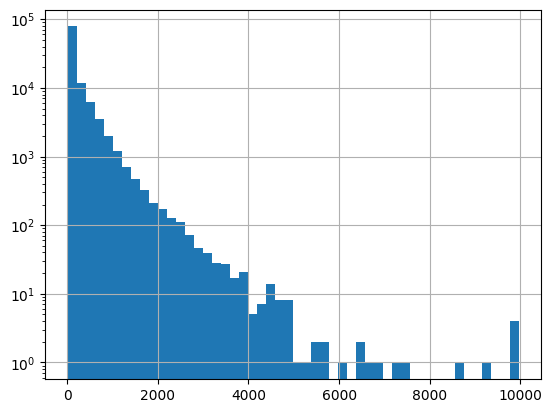

In [6]:
df["Commentaire"].str.len().hist(bins=50, log=True)

In [7]:
threshold = 40
mask_comments = (df["Commentaire"].str.strip().str.len()>threshold)
print(f"ratio of comments longer than {threshold:d} characters: {100*mask_comments.sum() / df.shape[0]:.2f}")

ratio of comments longer than 40 characters: 80.49


In [8]:
SAMPLE_NB = 2000
print("samples per star:", SAMPLE_NB)

tmp = pd.DataFrame(df[mask_comments])

samples = []

for star in range(1,6):
    satisfaction = "negative"
    if star==3:
        satisfaction = "neutral"
    elif star>3:
        satisfaction = "positive"
        
    mask = (tmp["star"]==star)
    sample = tmp.loc[mask, ["Commentaire", "cleaned_words", "cleaned_lemma", "star"]].sample(n=SAMPLE_NB)
    sample["satisfaction"] = satisfaction
    samples += [sample]

samples = pd.concat(samples)
samples = samples.reset_index(drop=True)

print("Samples:", samples.shape)
samples.head(5)

samples per star: 2000
Samples: (10000, 5)


,Commentaire,cleaned_words,cleaned_lemma,star,satisfaction
0,Une honte !!!! Un refus de paiement car soi di...,honte refus paiement disant vendeurs...,honte refus paiement dire vendeur f...,1,negative
1,"J'ai fait une commande chez Amazon, pour un an...",commande amazon anniversaire livraison ...,commande amazon anniversaire livraison ...,1,negative
2,"Bonjour,-je souhaite faire part d'une de mes n...","bonjour, je souhaite faire part mauvaises...","bonjour,-je souhaiter faire part mauvais ...",1,negative
3,"Service déplorable, commande effectuée fin Avr...",service déplorable commande effectuée fin avr...,service déplorable commande effectuer fin avr...,1,negative
4,J'ai acheté sur ce site une liseuse Kobo en se...,acheté site liseuse kobo septembre fon...,acheter site liseuse kobo septembre fo...,1,negative


In [9]:
outfile = os.path.join(DATA_FOLDER, "sample_topic_modeling.csv")
sample.to_csv(outfile, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

In [10]:
reviews = samples["Commentaire"].tolist()
cleaned_reviews = samples["cleaned_words"].tolist()
lemma_reviews = samples["cleaned_lemma"].tolist()
stars = samples["star"].tolist()

print("reviews:", len(reviews), end="\n\n")
print(reviews[10], end="\n\n")

print("lemmas:")
print(lemma_reviews[10])

reviews: 10000

J'ai commandé un article et je l'ai retourné aussitôt. Alors actuel il mon  prélevé 5 fois sur mn compte bancaire. J 'ai passé plus d'une demi-heure à essayé de récupérer mon argent. Alors actuel je suis tj au même point inadmissible. Je recommande même pas ce site 😡😡😡😡

lemmas:
commander  article     retourner aussitôt   actuel   prélever  fois  minute compte bancaire     passer    demi-heure  essayé  récupérer  argent   actuel   tj   point inadmissible   recommander    site


# Zero-shot-classification

In [11]:
def getPredictedClass(row):
    scores = row["scores"]
    indexes = np.argsort(scores)[::-1]
    classes = np.array(row["labels"])[indexes]
    return classes[0]

def getPredictions(model, reviews, topics):
    predictions = model(reviews, topics, multi_label=True)
    df = pd.DataFrame(predictions)
    df["topic"] = df.apply(getPredictedClass, axis=1)
    return df

In [15]:
os.environ["CUDA_VISIBLE_DEVICES"]="12"
os.environ["LD_LIBRARY_PATH"]="/data/appli_PITSI/HGX2//nvidia/cuda/install/cuda_11.2.1/lib64/:/data/appli_PITSI/HGX2/nvidia/cuda/install/cuda_11.2.1_compat/lib64:/data/appli_PITSI/HGX2/nvidia/cudnn/install/cudnn-11.2-linux-x64-v8.1.1.33/lib64"

In [17]:
# selecting a GPU with PyTorch (choose a free GPU!) 
GPU_NUMBER=0

# setting device on GPU if available, else CPU
device = torch.device("cuda:{0}".format(GPU_NUMBER) if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print("__Used Logical Devices: {0}".format(device))
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Device Name:",torch.cuda.get_device_name(GPU_NUMBER))
    print("__Device Total Memory: {} GB".format(round(torch.cuda.get_device_properties(device).total_memory/1024**3,1)))
    print("__Memory Usage: Allocated {0} GB, Cached {1} GB".format(
        round(torch.cuda.memory_allocated(device)/1024**3,1), 
        round(torch.torch.cuda.memory_reserved(device)/1024**3,1)))

__Used Logical Devices: cuda:0
__CUDNN VERSION: 8101
__Device Name: Tesla V100-SXM3-32GB
__Device Total Memory: 31.7 GB
__Memory Usage: Allocated 0.0 GB, Cached 0.0 GB


In [12]:
MODEL_FOLDER = os.path.join(RAW_MODEL_FOLDER, "bart-large-mnli")

classifier = pipeline("zero-shot-classification",
                      model=MODEL_FOLDER,
                      batch_size=64)#, device=device)

In [13]:
topics = ["livraison et reception",
          "commande achat paiement remboursement",
          "service client et conseil",
          "site web et market place",
          "choix et qualité des produits"
          ]

In [14]:
with threadpool_limits(limits=_MAX_WORKERS):
    dataset = ZeroShotDataset(reviews)
    predictions = getPredictions(classifier, dataset, topics)

In [ ]:
predictions["cleaned_reviews"] = cleaned_reviews
predictions["cleaned_lemma"] = lemma_reviews
predictions.head(5)

In [ ]:
outfile = os.path.join(DATA_FOLDER, "zero_shot_results.csv")
predictions.to_csv(outfile, sep=",", encoding="utf-8", quoting=csv.QUOTE_ALL, index=False)

In [ ]:
outfile = os.path.join(DATA_FOLDER, "zero_shot_results.csv")
predictions = pd.read_csv(outfile, sep=",", encoding="utf-8", engine="python")
predictions.head(5)

,sequence,labels,scores,topic,cleaned_reviews,cleaned_lemma
0,"Service client injoignable ,mieux vaut ne pas ...","['service client et conseil', 'paiement rembou...","[0.9757513403892517, 0.6328223347663879, 0.478...",service client et conseil,service client injoignable mieux vaut sou...,service client injoignable mieux valoir s...
1,J ai commende une manette ps4 idition limite l...,"['paiement remboursement et commande', 'servic...","[0.9973393678665161, 0.9476274251937866, 0.829...",paiement remboursement et commande,commende manette ps4 idition limite black bl...,commende manette ps4 idition limite black bl...
2,Venez cherchez votre dretritus je demande a to...,"['paiement remboursement et commande', 'servic...","[0.9778416156768799, 0.5973402857780457, 0.586...",paiement remboursement et commande,venez cherchez dretritus demande bérets v...,venir chercher dretritu demande béret ver...
3,Déçu d'Amazon qui bloque mon compte et annule ...,"['service client et conseil', 'choix et qualit...","[0.9755101799964905, 0.8936396241188049, 0.780...",service client et conseil,déçu amazon bloque compte annule commande...,décevoir amazon bloquer compte annuler co...
4,@FnacVousAide @Fnac La fédération des achats p...,"['paiement remboursement et commande', 'choix ...","[0.9741864800453186, 0.9597480297088623, 0.925...",paiement remboursement et commande,fnacvousaide fnac fédération achats cadres...,@fnacvousaide @fnac fédération achat cadre...


## Topic Information

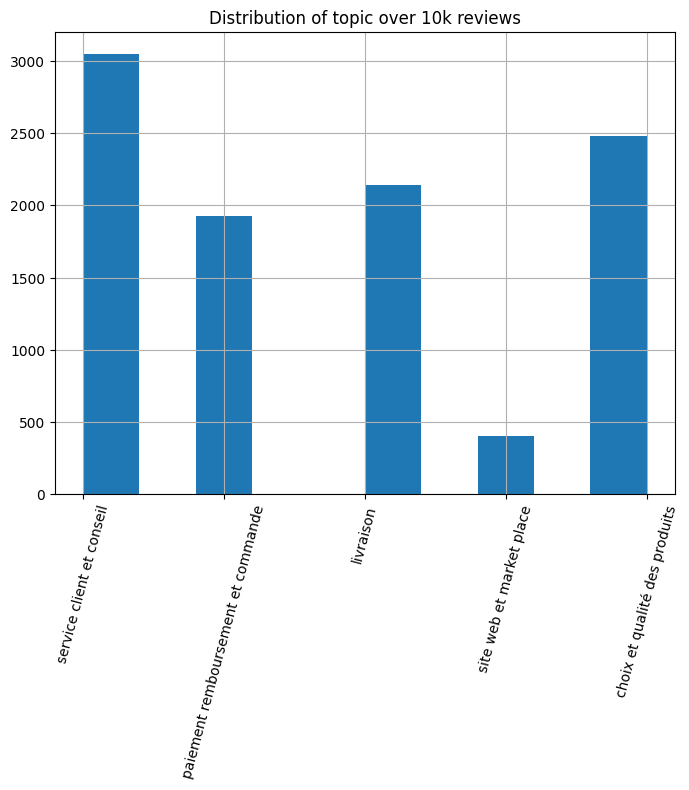

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
predictions["topic"].hist(ax=ax)
ax.xaxis.set_tick_params(rotation=75)
ax.set_title("Distribution of topic over 10k reviews")
plt.show()


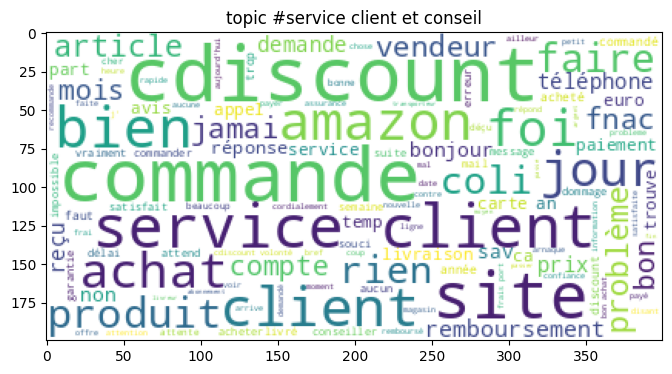

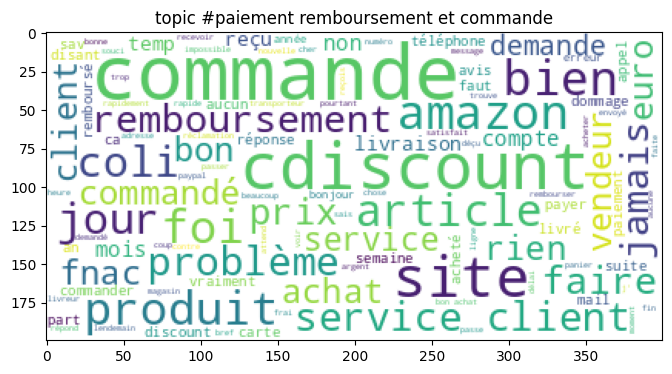

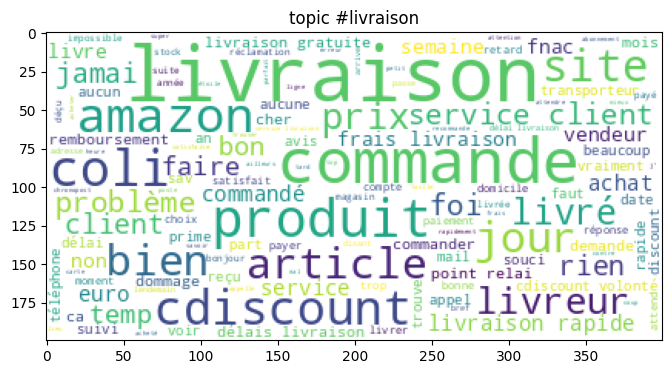

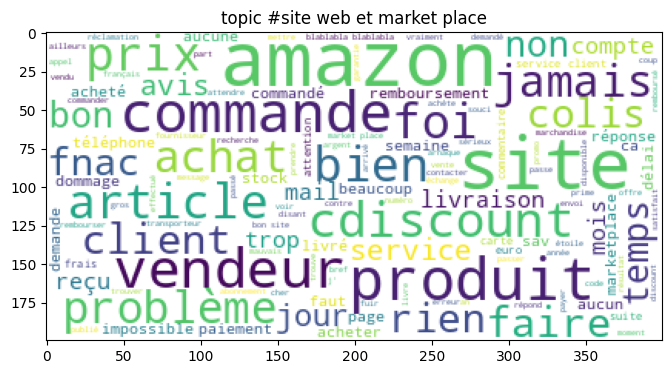

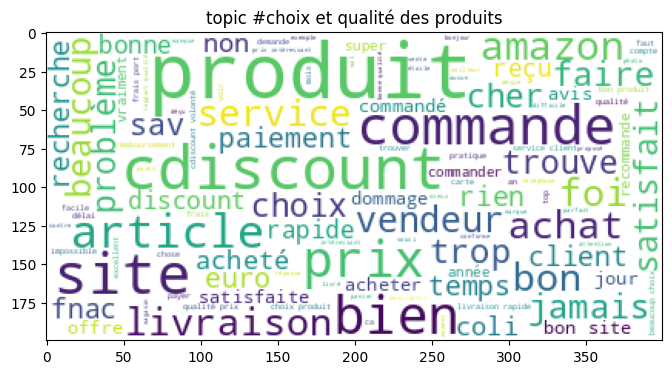

In [15]:
for topic in predictions["topic"].unique():
    mask = (predictions["topic"]==topic)
    text = " ".join(predictions.loc[mask, "cleaned_reviews"].tolist())
    plot_word_cloud(text, "topic #"+str(topic), stop_words,color='white', max_words=200, figsize=(8, 4))

In [35]:
index = choice(predictions.index)
review = predictions.at[index, "sequence"]

print("TEXT:")
showReview(review)

getZeroShotPredictions(predictions, index)

Très mauvais. Je n’ai pas reçu mon colis: 330 euros tout de même Il faut déjà se lever tôt pour
trouver un numéro où appeler car le site est déjà une vrai catastrophe ergonomique ! Bref le SAV me dit
qu’ils vont faire une enquête auprès du transporteur et qu’ils me rembourseront après mais ils sont incapables de me donner
un délai ! Ils m’ont envoyé un bon d’achat de 20 euros!Je voulais acheter sur un site français mais à
côté d’Amazon ils sont vraiment trop mauvaisOn se croirait dans l’ancie Allemagne de l’est!Je ne suis même pas sure d’etr
TEXT:
Très mauvais. Je n’ai pas reçu mon colis: 330 euros tout de même Il faut déjà se lever tôt pour trouver un numéro où appeler car le site est déjà une vrai catastrophe ergonomique ! Bref le SAV me dit qu’ils vont faire une enquête auprès du transporteur et qu’ils me rembourseront après mais ils sont incapables de me donner un délai ! Ils m’ont envoyé un bon d’achat de 20 euros!Je voulais acheter sur un site français mais à côté d’Amazon ils so

,labels,scores
0,service client et conseil,0.959906
1,paiement remboursement et commande,0.659271
2,choix et qualité des produits,0.649865
3,site web et market place,0.566451
4,livraison,0.478216


In [42]:
topics = ["livraison et reception",
          "commande achat paiement remboursement",
          "service client et conseil",
          "site web et market place",
          "choix et qualité des produits"
          ]

preds = getPredictions(classifier, [review], topics)
getZeroShotPredictions(preds, 0)

,labels,scores
0,service client et conseil,0.959906
1,commande achat paiement remboursement,0.771645
2,livraison et reception,0.666304
3,choix et qualité des produits,0.649865
4,site web et market place,0.566451
